# 0.Get Started

In [1]:
# !pip install matplotlib
# !pip install pandas
# !pip install scipy tqdm seaborn
# !pip install imutils

In [4]:
import cv2
from os import listdir
import math
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
from scipy import optimize
from tqdm import tqdm
import seaborn as sns
import dlib
import random
import xml.etree.ElementTree as ET
from imutils import face_utils

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# file_dir = 'drive/My Drive/Dr Chao/notebooks/'

file_dir = './'

lid_data_dir = file_dir + '../data/lid_data/'
lid_model_dir = file_dir + '../models/lid_models/'

## Inspect manual annotations

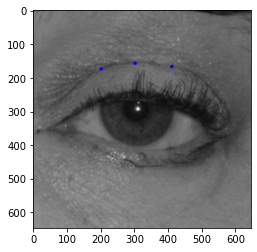

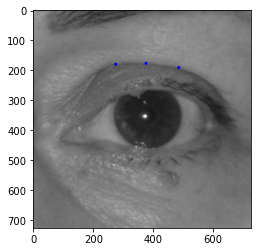

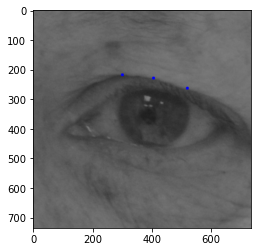

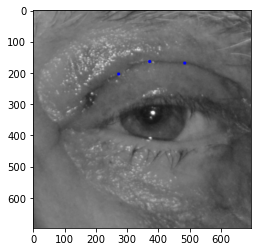

Error during parsing file: ./../data/lid_data/tmp/1011/Left/left_5.txt


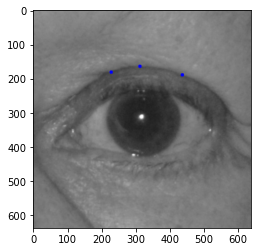

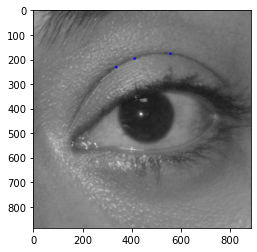

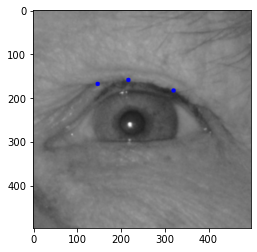

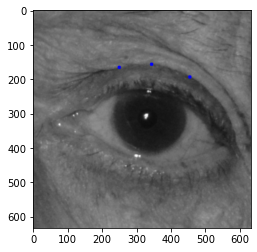

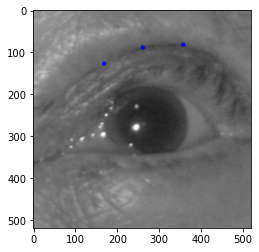

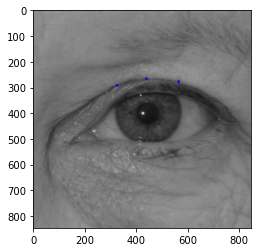

Error during parsing file: ./../data/lid_data/tmp/1011/Left/left_12.txt


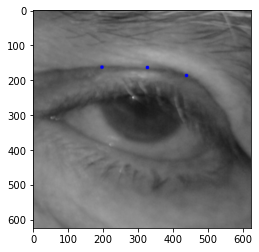

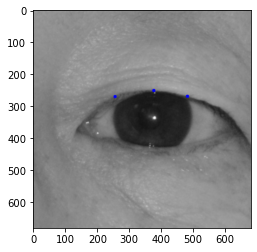

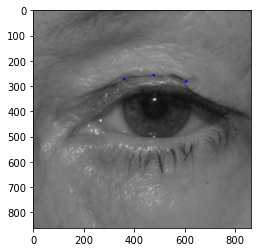

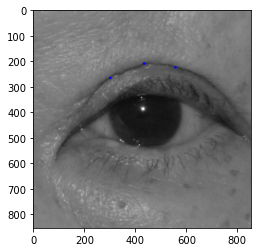

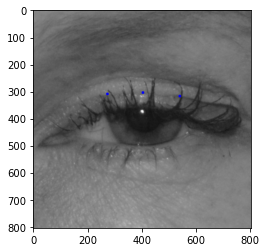

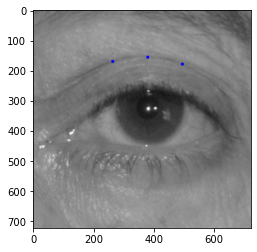

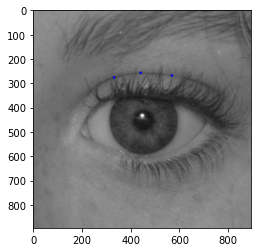

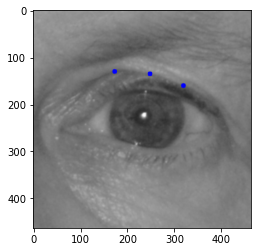

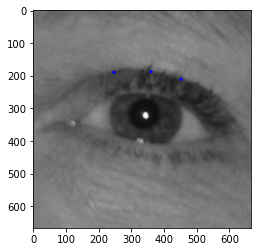

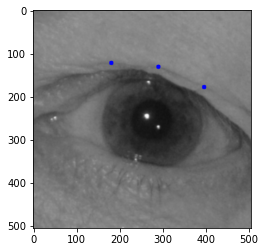

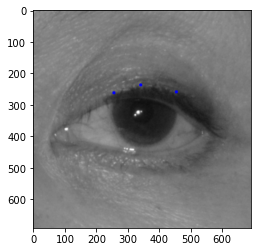

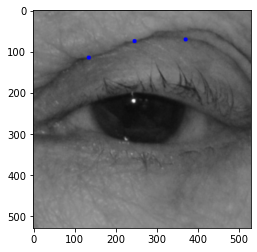

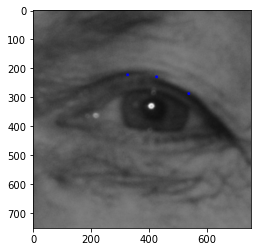

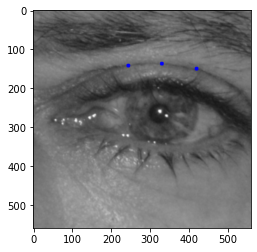

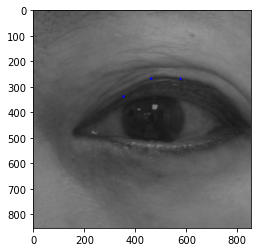

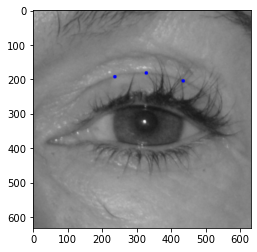

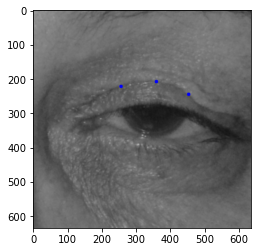

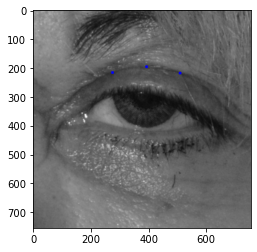

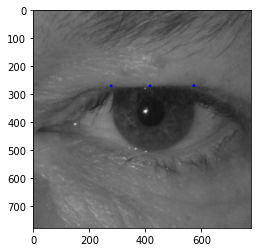

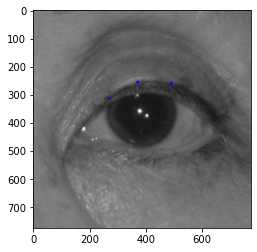

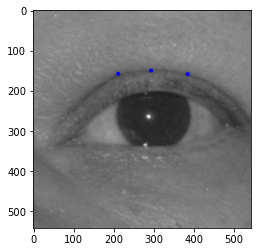

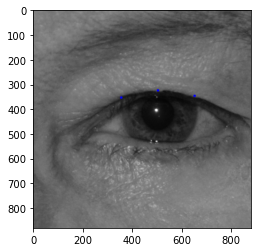

Error during parsing file: ./../data/lid_data/tmp/1011/Left/left_35.txt


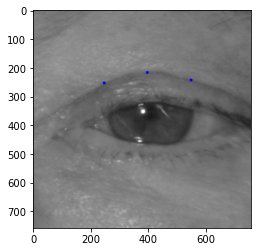

Error during parsing file: ./../data/lid_data/tmp/1011/Left/left_37.txt


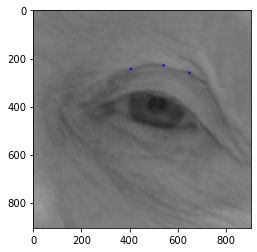

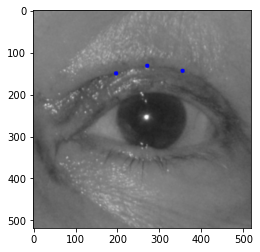

Error during parsing file: ./../data/lid_data/tmp/1011/Left/left_40.txt


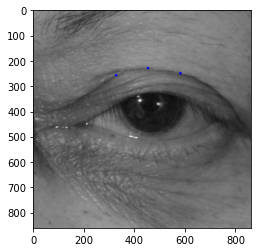

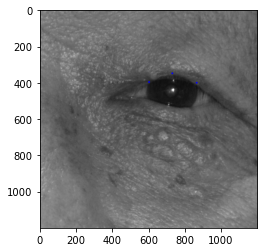

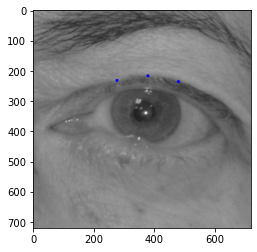

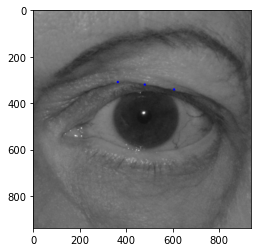

Error during parsing file: ./../data/lid_data/tmp/1011/Left/left_45.txt
Error during parsing file: ./../data/lid_data/tmp/1011/Left/left_46.txt


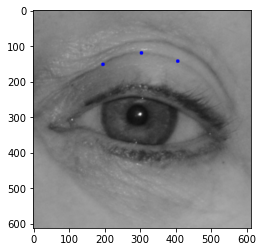

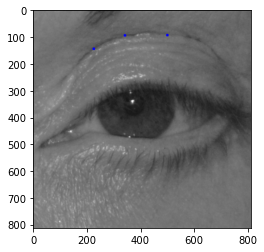

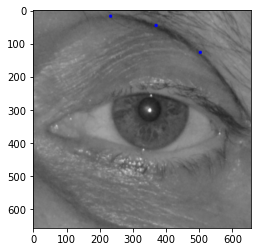

In [45]:
old_label_dir = lid_data_dir + 'tmp/0908/Left/'
new_label_dir = lid_data_dir + 'tmp/1011/Left/'
img_data_dir = '../data/processed/left/'

counter = 0
for idx in range(1, 50):
#     old_label = old_label_dir + 'SM_left_' + str(idx) + '.txt'
    new_label = new_label_dir + 'left_' + str(idx) + '.txt'
    img_path = img_data_dir + 'left_' + str(idx) + '.jpg'
    
#     old_points = []
#     try:
#         for line in open(old_label, 'r').readlines():
#             old_points.append([float(i) for i in line.split()])
#     except:
#         print('Error during parsing file:', old_label)
#         continue
        
    new_points = []
    try:
        for line in open(new_label, 'r').readlines():
            new_points.append([float(i) for i in line.split()])
    except:
        print('Error during parsing file:', new_label)
        continue
    
    
    # Points
#     img_old = cv2.imread(img_path)
#     for pair in old_points:
#         cv2.circle(img_old, (int(pair[0]), int(pair[1])), 5, (0, 0, 255), -1)
#     imgplot = plt.imshow(img_old)
#     plt.show()
    
    img_new = cv2.imread(img_path)
    for pair in new_points:
        cv2.circle(img_new, (int(pair[0]), int(pair[1])), 5, (0, 0, 255), -1)
    imgplot = plt.imshow(img_new)
    plt.show()
    
    
#     counter += 1
#     if counter > 10:
#         break

# 1.Process additinoal annotations

## 1.1. Read in points

In [16]:
# Left Eyes
curr_dir = lid_data_dir + 'raw_labels/Left/'
all_left_points_dict = {}
file_count = 0
for file in listdir(curr_dir):
    f = open(curr_dir + file, "r")
    counter = 0
    all_points = []
    try:
        for line in f.readlines():
            all_points.append([float(i) for i in line.split()])
            counter += 1
    except:
        print('Error during parsing file:', file)
        file_count += 1
        continue
        
    if counter != 3:
        print('Error for file:', file)
    else:
        all_left_points_dict[int(file.split('_')[-1].replace('.txt', ''))] = all_points
        # print(file)
    file_count += 1

In [17]:
print(file_count, len(list(all_left_points_dict.keys())), len(listdir(curr_dir)))

239 239 239


In [18]:
# Right Eyes
curr_dir = lid_data_dir + 'raw_labels/Right/'
all_right_points_dict = {}
file_count = 0
for file in listdir(curr_dir):
    f = open(curr_dir + file, "r")
    counter = 0
    all_points = []
    try:
        for line in f.readlines():
            all_points.append([float(i) for i in line.split()])
            counter += 1
    except:
        print('Error during parsing file:', file)
        file_count += 1
        continue
        
    if counter != 3:
        print('Error for file:', file)
    else:
        all_right_points_dict[int(file.split('_')[-1].replace('.txt', ''))] = all_points
        # print(file)
    file_count += 1

print(file_count, len(list(all_right_points_dict.keys())), len(listdir(curr_dir)))

Error during parsing file: .DS_Store
Error for file: right_196.txt
237 235 237


## 1.2. Train-test split

In [19]:
# Read in df_img_info
df_img_info = pd.read_csv(lid_data_dir + 'df_img_info.csv').query('both_found == 1').reset_index(drop = True)
df_img_info.head(2)

,original_name,orderred_name,left_found,right_found,both_found,left_hard,right_hard,left_failed,right_failed,dataset
0,2MM23355506081418-375.22.JPG,1.jpg,1,1,1,0,0,0,0,test
1,2ES30404089011618-374.87.JPG,2.jpg,1,1,1,0,0,0,0,train


In [13]:
# Doing the actual splitting - DO NOT RUN when testing

dataset = []
for i in range(df_img_info.shape[0]):
    ramd = random.random()
    if ramd < 0.6:
        dataset.append('train')
    elif ramd < 0.8:
        dataset.append('val')
    else:
        dataset.append('test')
df_img_info['dataset'] = dataset
df_img_info.head(2)

,original_name,orderred_name,left_found,right_found,both_found,left_hard,right_hard,left_failed,right_failed,dataset
0,2MM23355506081418-375.22.JPG,1.jpg,1,1,1,0,0,0,0,test
1,2ES30404089011618-374.87.JPG,2.jpg,1,1,1,0,0,0,0,train


In [20]:
dataset_dict = df_img_info[['dataset', 'orderred_name']]
dataset_dict.index = dataset_dict['orderred_name']
dataset_dict = dict(dataset_dict.dataset)
# dataset_dict

In [15]:
df_img_info.to_csv(lid_data_dir + 'df_img_info.csv', index = False)

## 1.3. Append to current annotations
- **Handle Left Eye** (Note: comes with manual annotations)

In [21]:
import xml.etree.ElementTree as ET

In [22]:
curr_success = []
curr_eye = 'left'
all_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_all.xml'

empty_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_empty.xml'
train_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_train.xml'
test_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_test.xml'
val_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_val.xml'

In [23]:
all_root = ET.parse(all_xml_file_path).getroot()
images = all_root.find('images')

for img in images.findall('image'):
    idx = int(img.attrib['file'].replace('left_', '').replace('.jpg', ''))
    if idx in all_left_points_dict.keys():
        points_to_append = all_left_points_dict[idx]
    box = img.find('box')
    counter = 9
    for p in points_to_append:
        part = ET.SubElement(box, 'part')
        part.set('name', str(counter))
        part.set('x', str(int(p[0])))
        part.set('y', str(int(p[1])))
        counter += 1

In [24]:
train_tree = ET.parse(empty_xml_file_path)
test_tree = ET.parse(empty_xml_file_path)
val_tree = ET.parse(empty_xml_file_path)

train_root = train_tree.getroot()
test_root = test_tree.getroot()
val_root = val_tree.getroot()
# all_root = ET.parse(all_xml_file_path).getroot()

images = all_root.find('images')
train_images = train_root.find('images')
test_images = test_root.find('images')
val_images = val_root.find('images')

all_count = len(all_root.findall('images/image'))
print('Count of labels:', all_count)

counter = 0
for img in images.findall('image'):
    orderred_name = img.attrib['file'].split('_')[-1]
    if orderred_name in dataset_dict.keys():
        if dataset_dict[orderred_name] == 'train':
            train_images.append(img)
        elif dataset_dict[orderred_name] == 'val':
            val_images.append(img)
        else:
            test_images.append(img)

Count of labels: 236


In [25]:
train_tree.write(train_xml_file_path)
test_tree.write(test_xml_file_path)
val_tree.write(val_xml_file_path)

# 2.Training

In [26]:
curr_success = []
curr_eye = 'left'
all_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_all.xml'

empty_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_empty.xml'
train_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_train.xml'
test_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_test.xml'
val_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_val.xml'

predictor_path = lid_model_dir + curr_eye + '_11_eyes_predictor.dat'

In [27]:
# import the necessary packages
import multiprocessing

def train(parameters):
#     print("===========================================")
#     print("[INFO] setting shape predictor options...")
    options = dlib.shape_predictor_training_options()
#     print(parameters)
    # [2-8]
    options.tree_depth = parameters['tree_depth']

    # regularization parameter 
    # [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.8]
    options.nu = parameters['nu']

    # [6, 18]
    options.cascade_depth = parameters['cascade_depth']

    # Larger for more accurate results & Slower inference
    options.feature_pool_size = parameters['feature_pool_size']

    # Larger for more accurate results & Slower training
    options.num_test_splits = parameters['num_test_splits']

    # controls amount of "jitter" (i.e., data augmentation) when training
    # the shape predictor -- applies the supplied number of random
    # deformations, thereby performing regularization and increasing the
    # ability of our model to generalize
    # [0, 50] 
    options.oversampling_amount = parameters['oversampling_amount']

    # amount of translation jitter to apply -- the dlib docs recommend
    # values in the range [0, 0.5]
    options.oversampling_translation_jitter = parameters['oversampling_translation_jitter']

    # tell the dlib shape predictor to be verbose and print out status
    # messages our model trains
    options.be_verbose = True

    # number of threads/CPU cores to be used when training -- we default
    # this value to the number of available cores on the system, but you
    # can supply an integer value here if you would like
    # options.num_threads = multiprocessing.cpu_count()
    options.num_threads = 2
    
    
    # train the shape predictor
    # print("[INFO] training shape predictor...")
    dlib.train_shape_predictor(train_xml_file_path, predictor_path, options)

In [28]:
first_trial = pd.read_csv(lid_model_dir + 'archived/Copy of first_trial.csv')
second_trial = pd.read_csv(lid_model_dir + 'archived/Copy of second_trial.csv')
third_trial = pd.read_csv(lid_model_dir + 'archived/Copy of third_trial.csv')
all_trials = pd.concat([first_trial, second_trial, third_trial]).sort_values('error').reset_index(drop = True)
all_trials.head(2)

,tree_depth,nu,cascade_depth,feature_pool_size,num_test_splits,oversampling_amount,oversampling_translation_jitter,error
0,4,0.03,18,800,50,35,0.35,1.985454
1,4,0.03,18,400,100,35,0.35,2.022114


In [29]:
performance_lst = []
for i in tqdm(range(30)):
    curr_model = dict(all_trials.iloc[i])
    curr_model['tree_depth'] = int(curr_model['tree_depth'])
    curr_model['cascade_depth'] = int(curr_model['cascade_depth'])
    curr_model['feature_pool_size'] = int(curr_model['feature_pool_size'])
    curr_model['num_test_splits'] = int(curr_model['num_test_splits'])
    curr_model['oversampling_amount'] = int(curr_model['oversampling_amount'])
    train(curr_model)
    error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
    curr_model['error'] = error
    performance_lst.append(curr_model)

100%|██████████| 30/30 [1:08:19<00:00, 136.63s/it]


In [32]:
result_df = pd.DataFrame(performance_lst).sort_values(by = 'error').reset_index(drop = True)
result_df.head()

,tree_depth,nu,cascade_depth,feature_pool_size,num_test_splits,oversampling_amount,oversampling_translation_jitter,error
0,4,0.03,18,800,100,35,0.35,14.523846
1,4,0.03,18,400,100,35,0.35,14.568413
2,4,0.03,18,800,50,35,0.35,14.714837
3,4,0.01,18,800,100,35,0.35,14.721553
4,4,0.03,18,800,75,35,0.40,14.722887


In [31]:
result_df.to_csv(lid_model_dir + 'result.csv', index = False)

# 3. Testing

In [34]:
curr_success = []
curr_eye = 'left'
all_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_all.xml'

empty_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_empty.xml'
train_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_train.xml'
test_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_test.xml'
val_xml_file_path = file_dir + '../data/lid_data/' + curr_eye + '/' + curr_eye + '_eyes_11points_val.xml'

In [35]:
# Read in df_img_info
df_img_info = pd.read_csv(lid_data_dir + 'df_img_info.csv').query('both_found == 1').reset_index(drop = True)
df_img_info.head(2)

,original_name,orderred_name,left_found,right_found,both_found,left_hard,right_hard,left_failed,right_failed,dataset
0,2MM23355506081418-375.22.JPG,1.jpg,1,1,1,0,0,0,0,test
1,2ES30404089011618-374.87.JPG,2.jpg,1,1,1,0,0,0,0,train


In [36]:
# Read in result_df
result_df = pd.read_csv(lid_model_dir + 'result.csv')
selected_model = dict(result_df.iloc[0])
result_df.head()

,tree_depth,nu,cascade_depth,feature_pool_size,num_test_splits,oversampling_amount,oversampling_translation_jitter,error
0,4,0.03,18,800,100,35,0.35,14.523846
1,4,0.03,18,400,100,35,0.35,14.568413
2,4,0.03,18,800,50,35,0.35,14.714837
3,4,0.01,18,800,100,35,0.35,14.721553
4,4,0.03,18,800,75,35,0.40,14.722887


In [37]:
# curr_model = selected_model
# curr_model['tree_depth'] = int(curr_model['tree_depth'])
# curr_model['cascade_depth'] = int(curr_model['cascade_depth'])
# curr_model['feature_pool_size'] = int(curr_model['feature_pool_size'])
# curr_model['num_test_splits'] = int(curr_model['num_test_splits'])
# curr_model['oversampling_amount'] = int(curr_model['oversampling_amount'])
# train(curr_model)

In [38]:
predictor_path = lid_model_dir + 'left_11_eyes_predictor.dat'
print('Loading predictor from:', predictor_path)
predictor = dlib.shape_predictor(predictor_path)

def predict_landmarks(filepath, predictor):
    """
    Predicting the landmarks given a image filepath and a predictor object
    nput:
        - filepath       : filepath to the image
        - predictor      : predictor object
    return:
        - image          : output image
        - shape          : list of landmark locations
    """

    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(filepath)
    # image = imutils.resize(image, width = 250)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    h, w = image.shape[0], image.shape[1]
    rects = dlib.rectangles()
    rec = dlib.rectangle(0, 0, w, h)
    rects.append(rec)
    
    shape = 0
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),\
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
    return image, shape

Loading predictor from: ./../models/lid_models/left_11_eyes_predictor.dat


In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/joey-hou/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'box']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [43]:
counter = 0
output_dir = lid_data_dir + '../final_output/lid_proj_output/'
for file_name in df_img_info.query('dataset in ["test", "val"]').orderred_name.values:
    full_path = lid_data_dir + curr_eye + '/' + curr_eye + '_' + file_name
    image, shape = predict_landmarks(full_path, predictor)
    cv2.imwrite(output_dir + curr_eye + '_' + file_name, image)
    
    
#     imgplot = plt.imshow(image)
#     plt.show()
#     counter += 1
#     if counter > 10:
#         break